# Binary & Fine Grained Sentiment Notebook

In this notebook we will create a model that predicts the sentiment of a piece of text. This prediction can only be positive or negative for the "binary" prediction. The "fine grained" prediction should also include the probability (score) and if the text was neutral. That is why we will use the [Twitter Sentiment Dataset](https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset?select=train.csv).

This dataset contains 27481 tweets that are labeled as positive, negative or neutral (we only need pos/neg).

The reason we are using this dataset is because it is a very small dataset. This means that we can train a model on it in a reasonable amount of time. The result should not be impacted that gravely by the small size of the dataset.

We've also chosen the Twitter dataset (instead of the IMDB dataset) because it is a more realistic dataset. The IMDB dataset contains movie reviews, which are very different from tweets or real life comments.

In [132]:
# import dependencies

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pickle

## Data Analysis

In [133]:
df = pd.read_csv("data/data.csv", encoding="latin-1")

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [135]:
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


Looking at this dataset, we can see in the second observation that there are HTML tags, punctuation, and other non-letter characters. We will need to remove these before we can train a model. 

## Data Analysis - Missing Values

In [136]:
df.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

## Data Analysis - Classes

<Axes: xlabel='sentiment'>

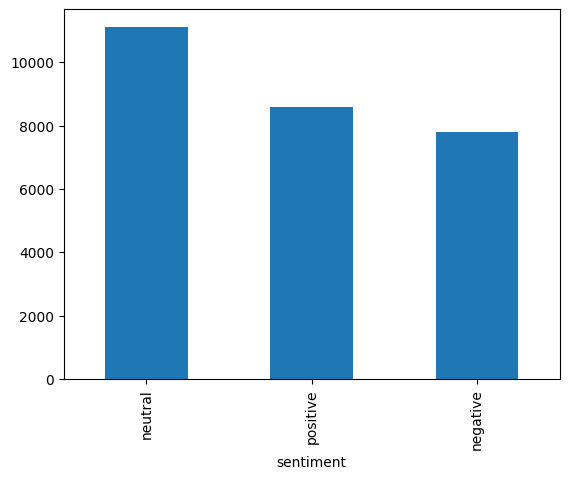

In [137]:
df['sentiment'].value_counts().plot(kind='bar')

In [138]:
df['sentiment'].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

## Data Preprocessing

### Steps

1. Handle the inconsistency found in the "Data Analysis" section
2. Split the data into train and test sets
3. Encode string labels (positive, negative) to integers (1, 0)
4. Preprocess the text data (tokenize, pad, and truncate)
5. Apply a word embedding


In [139]:
# drop missing values

df = df.dropna()

In [140]:
# keep only 'text' and 'sentiment' columns

df = df[['text', 'sentiment']]

In [141]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 644.1+ KB


There is a relatively equal amount of positive and negative tweets in this dataset. We don't need to perform any balancing of the dataset.

In [143]:
# split the data into train and test sets

X = df['text'].values
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print('Training Data :', X_train.shape[0])
print('Testing Data : ', X_test.shape[0])

Training Data : 21984
Testing Data :  5496


In [144]:
# Encode the string labels into numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert the numerical labels to one-hot encoded vectors
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Pickle the label encoder for future (api) use
with open('label_encoder.pkl', 'wb') as le_dump_file:
    pickle.dump(label_encoder, le_dump_file)

In [145]:
# preprocessing data

def text_preprocessing(text, language, minWordSize):
	# remove non-letters
	text = re.sub('[^a-zA-Z]', ' ', text)
	text = text.lower()
	words = text.split()

	# remove stop words
	stop_words = set(stopwords.words(language))
	text_no_stop_words = ' '
	words = [w for w in words if not w in stop_words]
	
	# remove words less than minWordSize
	words = [w for w in words if len(w) >= minWordSize]

	# keep 'not' and 'no' ... in stop words
	whitelist = ["n't", "not", "no"]
	for word in text.split():
		if word not in stop_words or word in whitelist:  
			text_no_stop_words = text_no_stop_words + word + ' '

	# stemming
	text_stemmer = ' '
	stemmer = SnowballStemmer(language)
	for w in text_no_stop_words.split():
		text_stemmer = text_stemmer + stemmer.stem(w) + ' '

	return text_no_stop_words

In [146]:
X_train_df = pd.DataFrame(X_train, columns=['text'])
X_test_df = pd.DataFrame(X_test, columns=['text'])

language = 'english'
minWordLength = 2

for i in range(X_train_df.shape[0]):
    X_train_df['text'].iloc[i] = text_preprocessing(X_train_df['text'].iloc[i], language, minWordLength)

for i in range(X_test_df.shape[0]):
    X_test_df['text'].iloc[i] = text_preprocessing(X_test_df['text'].iloc[i], language, minWordLength)

X_train = X_train_df['text'].values
X_test = X_test_df['text'].values

In [147]:
import pickle

# Convert to bag-of-words representation
count_vect = CountVectorizer()
X_train_bag_of_words = count_vect.fit_transform(X_train)
X_test_bag_of_words = count_vect.transform(X_test)

# Save the CountVectorizer object
with open('count_vectorizer.pkl', 'wb') as f:
    pickle.dump(count_vect, f)

# Apply TF-IDF transformation
tfidf_transformer = TfidfTransformer()
X_train_tf = tfidf_transformer.fit_transform(X_train_bag_of_words)
X_test_tf = tfidf_transformer.transform(X_test_bag_of_words)

# Save the TfidfTransformer object
with open('tfidf_transformer.pkl', 'wb') as f:
    pickle.dump(tfidf_transformer, f)

## Creating the model

### Steps

1. Build a model (Logistic Regression)
2. Train the model

Only Logistic Regression is used, because the other models are too slow to train. This Logistic Regression also produces very good results for the task of sentiment analysis.

#### Logistic Regression - Model

In [148]:
# Convert one-hot encoded labels to 1D array
y_train_1d = np.argmax(y_train, axis=1)

model = LogisticRegression()
parameters = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000, 100000]}]
logistic_grid_search = GridSearchCV(estimator=model, param_grid=parameters,
scoring='accuracy', cv=4, n_jobs=-1)

logistic_grid_search = logistic_grid_search.fit(X_train_tf, y_train_1d)

best_accuracy = logistic_grid_search.best_score_
best_parameters = logistic_grid_search.best_params_

print('Best accuracy:', best_accuracy)
print('Best parameters:', best_parameters)

Best accuracy: 0.6760826055312956
Best parameters: {'C': 1}


c:\Users\denis\.virtualenvs\server-L9IasW_S\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


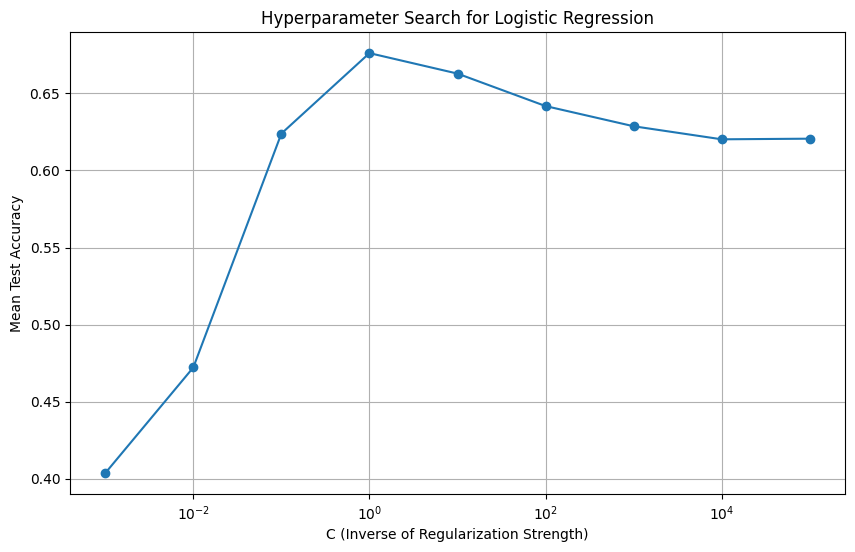

In [149]:
params = logistic_grid_search.cv_results_['params']
mean_test_scores = logistic_grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.semilogx([param['C'] for param in params], mean_test_scores, marker='o')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Mean Test Accuracy')
plt.title('Hyperparameter Search for Logistic Regression')
plt.grid(True)
plt.show()

In [150]:
best_model = logistic_grid_search.best_estimator_

## Testing the model

### Steps

1. Evaluate the model on the test set
2. Make predictions on custom reviews

The ROC curve for the model is shown above. The AUC score is 0.94.

In [152]:
y_pred = best_model.predict(X_test_tf)

y_pred_one_hot = to_categorical(y_pred, num_classes=num_classes)

# accuracy score
accuracy = accuracy_score(y_test, y_pred_one_hot)
print('Accuracy: ', accuracy)

# classification report
report = classification_report(y_test, y_pred_one_hot)
print('Classification Report:\n', report)

Accuracy:  0.6952328966521106
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.61      0.66      1528
           1       0.64      0.75      0.69      2243
           2       0.77      0.71      0.73      1725

   micro avg       0.70      0.70      0.70      5496
   macro avg       0.71      0.69      0.69      5496
weighted avg       0.70      0.70      0.70      5496
 samples avg       0.70      0.70      0.70      5496



In [153]:
# Save best model
with open('model/sentiment_model.pkl', 'wb') as f:
	pickle.dump(best_model, f)

In [154]:
# Load the saved model
with open('model/sentiment_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load the saved label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Load the saved count vectorizer
with open('count_vectorizer.pkl', 'rb') as f:
    count_vect = pickle.load(f)

# Load the saved tfidf transformer
with open('tfidf_transformer.pkl', 'rb') as f:
    tfidf_transformer = pickle.load(f)

In [155]:
# Preprocess new text

sentences = ["Why did you do that? I'm very disappointed", "I loved this movie.", "Hello everyone!"]

for sentence in sentences:
	preprocessed_text = text_preprocessing(sentence, language, minWordLength)
	new_text_bag_of_words = count_vect.transform([preprocessed_text])
	new_text_tf = tfidf_transformer.transform(new_text_bag_of_words)

	predicted_sentiment = model.predict(new_text_tf)
	predicted_sentiment_label = label_encoder.inverse_transform(predicted_sentiment)

	# Get probabilities for each class
	probabilities = model.predict_proba(new_text_tf)[0]

	print(f"Given sentence: {sentence}")
	print(f"Predicted sentiment: {predicted_sentiment_label[0]}")
	print(f"Probabilities: {probabilities} \n")

Given sentence: Why did you do that? I'm very disappointed
Predicted sentiment: negative
Probabilities: [0.81953723 0.1604403  0.02002247] 

Given sentence: I loved this movie.
Predicted sentiment: positive
Probabilities: [0.02367905 0.1088268  0.86749415] 

Given sentence: Hello everyone!
Predicted sentiment: neutral
Probabilities: [0.09587793 0.7022926  0.20182948] 



## Functions to be used in the API

In this part we will create the functions that will be used inside the API. ``get_binary_sentiment`` and ``get_fine_grained_sentiment`` will be used. The output will be in json format.

In [156]:
def text_sentiment_preprocessing(text, language, minWordLength, model, count_vect, tfidf_transformer, label_encoder):
	preprocessed_text = text_preprocessing(text, language, minWordLength)
	new_text_bag_of_words = count_vect.transform([preprocessed_text])
	new_text_tf = tfidf_transformer.transform(new_text_bag_of_words)

	predicted_sentiment = model.predict(new_text_tf)
	predicted_sentiment_label = label_encoder.inverse_transform(predicted_sentiment)

	predicted_probabilities = model.predict_proba(new_text_tf)
	prediction_amount = predicted_probabilities[0][predicted_sentiment[0]].round(2)

	return predicted_sentiment_label[0], prediction_amount

In [157]:
def get_binary_sentiment(text, language, minWordLength, model, count_vect, tfidf_transformer, label_encoder):
	
	predicted_label, predicted_amount = text_sentiment_preprocessing(text=text, language=language, minWordLength=minWordLength, model=model, count_vect=count_vect, tfidf_transformer=tfidf_transformer, label_encoder=label_encoder)

	result = {
		"text": text,
		"sentiment": predicted_label,
	}

	if predicted_sentiment_label == "neutral":
		result["sentiment"] = "positive"

	return result

In [158]:
text = "This"

In [159]:
get_binary_sentiment(text=text, language="english", minWordLength=2, model=model, count_vect=count_vect, tfidf_transformer=tfidf_transformer, label_encoder=label_encoder)

{'text': 'This', 'sentiment': 'positive'}

In [160]:
def get_fine_grained_sentiment(text, language, minWordLength, model, count_vect, tfidf_transformer, label_encoder):

	predicted_label, predicted_amount = text_sentiment_preprocessing(text, language, minWordLength, model, count_vect, tfidf_transformer, label_encoder)

	result = {
		"text": text,
		"sentiment": predicted_label,
		"score": predicted_amount
	}

	return result

In [161]:
text = "This is the best movie I have ever seen!"

In [162]:
get_fine_grained_sentiment(text=text, language="english", minWordLength=2, model=model, count_vect=count_vect, tfidf_transformer=tfidf_transformer, label_encoder=label_encoder)

{'text': 'This is the best movie I have ever seen!',
 'sentiment': 'positive',
 'score': 0.85}